In [1]:
import sys
import os
import torch
import torch.nn.functional as F
from torchvision.datasets import CIFAR100, MNIST
from torchvision import transforms
from tqdm import trange
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
import umap.umap_ as umap
from pytorch_pretrained_vit import ViT
import json
import PIL
from PIL import Image
from tqdm import tqdm, trange
from colors import blue, red, green, cyan
from collections import Counter
from transformers import BertTokenizer
import yaml
from scipy.optimize import linear_sum_assignment
import math

/Users/annhe/anaconda3/envs/modality_gap/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
data = json.load(open('data/COCO/annotations/captions_val2017.json'))
id2file = {item['id']: item['coco_url'] for item in data['images']}
id2caption = {item['image_id']: item['caption'] for item in data['annotations']}
file2caption = {id2file[id]: id2caption[id] for id in id2caption}
filenames = [(filename, file2caption[filename]) for filename in file2caption]

In [3]:
import voyageai as vo

100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 22892.67it/s]


Getting embeddings from Voyage...
Retrieval accuracy: 0.716


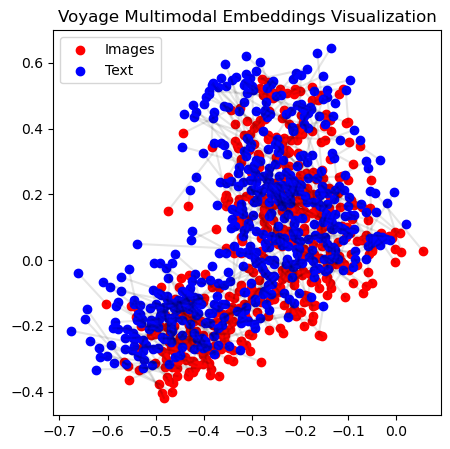

Processed 5866 text tokens and 135565070 image pixels
Total tokens: 247946


In [4]:
# Initialize Voyage client
vo_client = vo.Client()  # Uses VOYAGE_API_KEY from environment
MODEL_NAME = "voyage-multimodal-3"  # or whichever model you're using

# Prepare data for Voyage
inputs = []
for filename in tqdm(list(file2caption.keys())[:500]):  # Limit to 500 like original
    caption = file2caption[filename]
    local_filename = f"data/COCO/{filename.replace('http://images.cocodataset.org/', '')}"
    
    # Add image input as a list containing PIL Image
    inputs.append([Image.open(local_filename)])
    
    # Add text input as a list containing text string
    inputs.append([caption])

# Get embeddings from Voyage
print("Getting embeddings from Voyage...")
result = vo_client.multimodal_embed(
    inputs=inputs,
    model=MODEL_NAME,
)

# Extract embeddings
all_embeddings = np.array(result.embeddings)

# Split into image and text features (every other embedding)
image_features = all_embeddings[::2]  # Even indices (0, 2, 4, ...)
text_features = all_embeddings[1::2]  # Odd indices (1, 3, 5, ...)

# Convert to torch tensors
image_features = torch.tensor(image_features)
text_features = torch.tensor(text_features)

# Calculate retrieval accuracy (like original CLIP code)
accuracy = ((image_features @ text_features.T).argmax(dim=-1) == torch.arange(len(image_features))).float().mean()
print(f"Retrieval accuracy: {accuracy:.3f}")

# Save features
np.save('features_voyage_random.npy', [image_features.float().numpy(), text_features.float().numpy()])

# Visualization (same as original)
all_img_features, all_text_features = np.load('features_voyage_random.npy')

def svd(X, n_components=2):
    U, S, Vt = np.linalg.svd(X)
    return U[:, :n_components] * S[:n_components]

features_2d = svd(np.concatenate([all_img_features, all_text_features], 0))

plt.figure(figsize=(5, 5))
plt.scatter(features_2d[:len(all_img_features), 0], features_2d[:len(all_img_features), 1], c='red', label='Images')
plt.scatter(features_2d[len(all_img_features):, 0], features_2d[len(all_img_features):, 1], c='blue', label='Text')

# Connect corresponding image-text pairs
for i in range(len(all_img_features)):
    plt.plot([features_2d[i, 0], features_2d[len(all_img_features)+i, 0]], 
             [features_2d[i, 1], features_2d[len(all_img_features)+i, 1]], 
             c='black', alpha=0.1)

plt.legend()
plt.title('Voyage Multimodal Embeddings Visualization')
plt.show()

print(f"Processed {result.text_tokens} text tokens and {result.image_pixels} image pixels")
print(f"Total tokens: {result.total_tokens}")